### Downloading CHB-MIT EEG Datasets

In [ ]:
# Dataset 1 : gs://chbmit-1.0.0.physionet.org

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wget

In [ ]:
from wget import download
import os
from os import chdir, getcwd, mkdir, path

In [ ]:
folders = 24
dataset_path = 'test'
base_url = 'https://archive.physionet.org/pn6/chbmit/'

In [ ]:
list_of_folders = []
for i in range (1, folders+1):
    if i<10:
        name = 'chb0'
    else:
        name = 'chb'
    list_of_folders.append(name + str(i))

In [ ]:
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start + len(needle))
        n -= 1
    return start

In [ ]:
initial_path = getcwd()
if not path.exists(dataset_path):
    mkdir(dataset_path)
chdir(dataset_path)


files = []
# for every folder contained in the dataset
for l in list_of_folders:

    # check if the folder already exists, otherwise create it
    if not path.exists(l):
        mkdir(l)
        print('Creation of the directory', l, 'succeeded')
    else:
        print ('Directory', l,  'already exists')

    # change the working directory to the current list's file
    chdir(l)

    # for the current folder, download the 'MD5SUMS' file that enumerates all the files contained in the folder.
    # save the names of the files in a list
    folder_url = base_url + l
    url = folder_url + '/' + 'MD5SUMS'
    print ('Downloading ', url, 'to ', getcwd())
    if not path.isfile('MD5SUMS'):
        download(url)
    else:
        print('File MD5SUMS already exists to ', getcwd())
    f = open('MD5SUMS','r')
    lines = f.readlines()
    f.close()
    # for each folder download all the files that contains
    for line in lines:
        fname = line[line.find('chb'):line.find('\n')].strip()
        url = folder_url + '/' + fname

        # check if we have already downloaded the file
        if not path.isfile(fname) and fname.endswith('.seizures'):
            print ('Downloading ', url[:find_nth(url, '.seizures', 1)], 'to ', getcwd())
            download(url[:find_nth(url, '.seizures', 1)])
            print ('Downloading ', url, 'to ', getcwd())
            download(url)

    # change the working directory to the parent folder
    chdir('..')
chdir(initial_path)

Directory chb01 already exists
File MD5SUMS already exists to  /content/test/chb01
Creation of the directory chb02 succeeded
Creation of the directory chb03 succeeded
Creation of the directory chb04 succeeded
Creation of the directory chb05 succeeded
Creation of the directory chb06 succeeded
Creation of the directory chb07 succeeded
Creation of the directory chb08 succeeded
Creation of the directory chb09 succeeded
Creation of the directory chb10 succeeded
Creation of the directory chb11 succeeded
Creation of the directory chb12 succeeded
Creation of the directory chb13 succeeded
Creation of the directory chb14 succeeded
Creation of the directory chb15 succeeded
Creation of the directory chb16 succeeded
Creation of the directory chb17 succeeded
Creation of the directory chb18 succeeded
Creation of the directory chb19 succeeded
Creation of the directory chb20 succeeded
Creation of the directory chb21 succeeded
Creation of the directory chb22 succeeded
Creation of the directory chb23 suc

In [ ]:
getcwd()

'/content'

### Preprocessing CHB-MIT EEG Database


In [ ]:
!pip install wfdb
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 50.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging

In [ ]:
# Creating a list in Python called ch_labels that contains labels for 18 EEG channels
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

In [ ]:
# Patients' ID are extracted by folder names

path2pt = '/content/test'

folders = sorted(glob.glob(path2pt+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

print(*n_patient)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [ ]:
# Patients are randomly divided into training and test groups
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [ ]:
# file names for training and test data

files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [ ]:
len(files_train), len(files_test)

(116, 25)

In [ ]:
mne.set_log_level(verbose='ERROR')

Each 8 second signals of 18 channels are extracted, sliding forward by 4 seconds.
Each set of signals are labeled with the ratio of seizure in the time window. i.e. a set of signals are labeled 1.0 if it is in the middle of seizure.

In [ ]:
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

time_window = 8
time_step = 4

if os.path.exists('/content/signal_samples.npy')& os.path.exists('/content/is_sz.npy'):
    array_signals=np.load('/content/signal_samples.npy')
    array_is_sz=np.load('/content/is_sz.npy')
else:
    p = 0.01
    counter = 0
    for temp_f in files_train:
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz = np.zeros((temp_edf.n_times,))
            if os.path.exists(temp_f+'.seizures'):
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            temp_len = temp_edf.n_times

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            counter = counter + temp_0_sample_size + temp_1_sample_size
        temp_edf.close()

    array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
    array_is_sz = np.zeros(counter, dtype=bool)

    counter = 0
    for n, temp_f in enumerate(tqdm.tqdm(files_train)):
        to_log = 'No. {}: Reading. '.format(n)
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
        if n_label_match==len(ch_labels):
            ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
            temp_edf.rename_channels(ch_mapping)
            #temp_edf = temp_edf.pick(ch_labels)

            temp_is_sz = np.zeros((temp_edf.n_times,))
            temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

            if os.path.exists(temp_f+'.seizures'):
                to_log = to_log+'sz exists.'
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            else:
                to_log = to_log+'No sz.'

            temp_len = temp_edf.n_times

            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )
            del temp_is_sz

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            # sz data
            temp_ind = list(np.where(temp_is_sz_ind>0)[0])
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = True
                counter = counter+1

            # no sz data
            temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = False
                counter = counter+1

            to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
                temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
            )

        else:
            to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)

        logger.info(to_log)
        temp_edf.close()

        if n%10==0:
            gc.collect()
    gc.collect()

    np.save('signal_samples', array_signals)
    np.save('is_sz', array_is_sz)

100%|██████████| 116/116 [02:56<00:00,  1.52s/it]


In [ ]:
array_signals.shape

(3913, 18, 2048)

In [ ]:
array_signals = array_signals[:, :, ::2]
array_signals.shape

(3913, 18, 1024)

1. Signals frequencies are originally 256 Hz, but resampled to 128 Hz for simplification of the data.

1. The code array_signals = array_signals[:, :, ::2] is using NumPy array slicing to select a subset of elements from the array_signals array. Let's break down what each part of the slicing does:

1. The first colon : before the comma refers to all elements along the first axis (axis 0). This means it selects all samples or instances in the dataset.

1. The second colon : after the first comma refers to all elements along the second axis (axis 1). This means it selects all channels.

1. The ::2 after the second comma is a step parameter. In this case, it means "take every second element along the third axis (axis 2)."

1. Putting it all together, array_signals[:, :, ::2] selects all samples and all channels from the original array_signals, but only every second element along the time axis (axis 2).

1. If the original shape of array_signals was (n, 18, 8 * 256), the resulting shape of array_signals after this slicing would be (n, 18, 8 * 128) because it reduces the number of elements along the time axis by half.

1. This kind of slicing is used for downsampling or reducing the temporal resolution of time series data. In EEG data, it is be done to reduce the number of time points while still retaining essential information, possibly for computational efficiency or to focus on specific features of interest in the signal

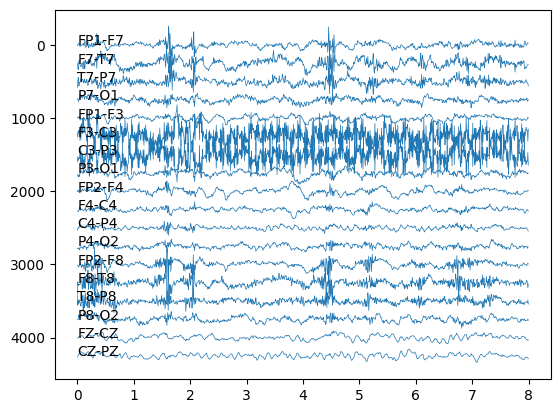

In [ ]:
# show a sample of extracted signals (the last one)

vertical_width = 250
signals = array_signals[-1, :, :]
fs = 128

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [ ]:
# Checking how much of signals have seizure inside.
array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

Number of all the extracted signals: 3913
Number of signals with seizures: 2581
Ratio of signals with seizures: 0.660


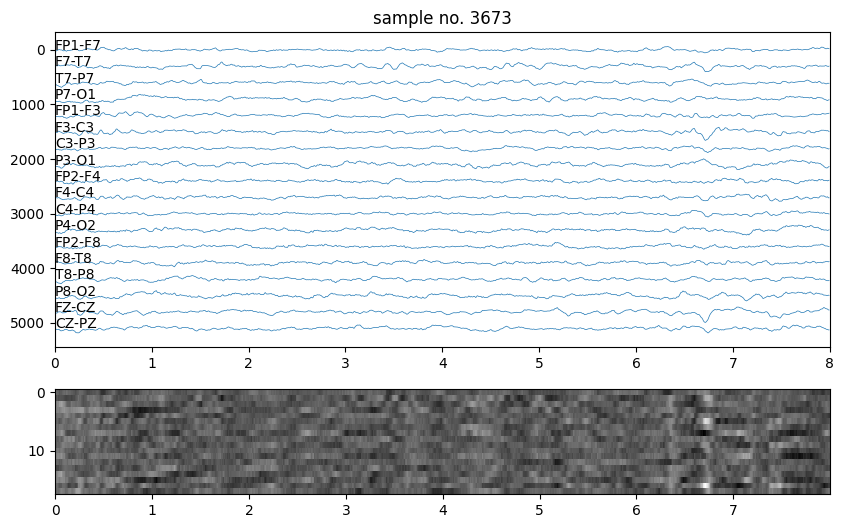

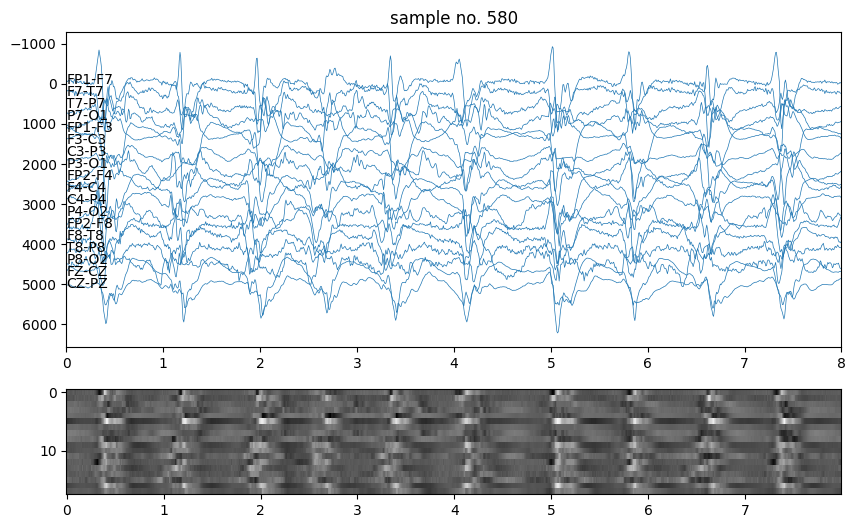

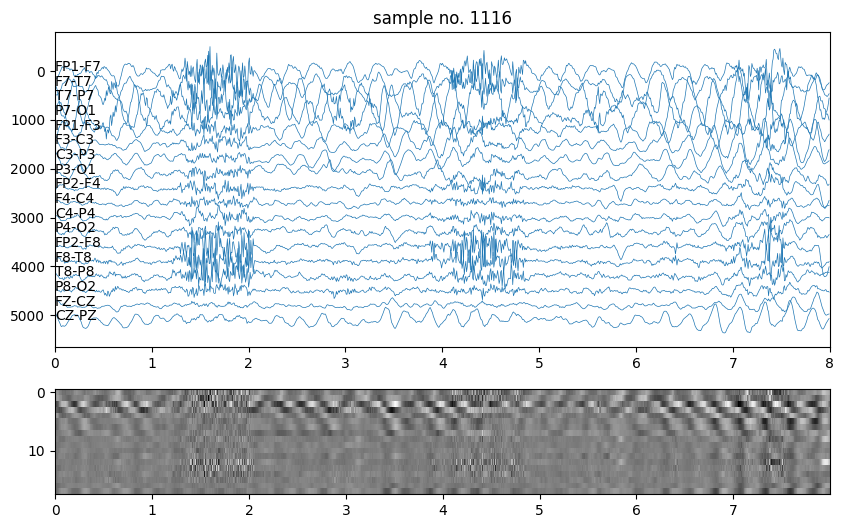

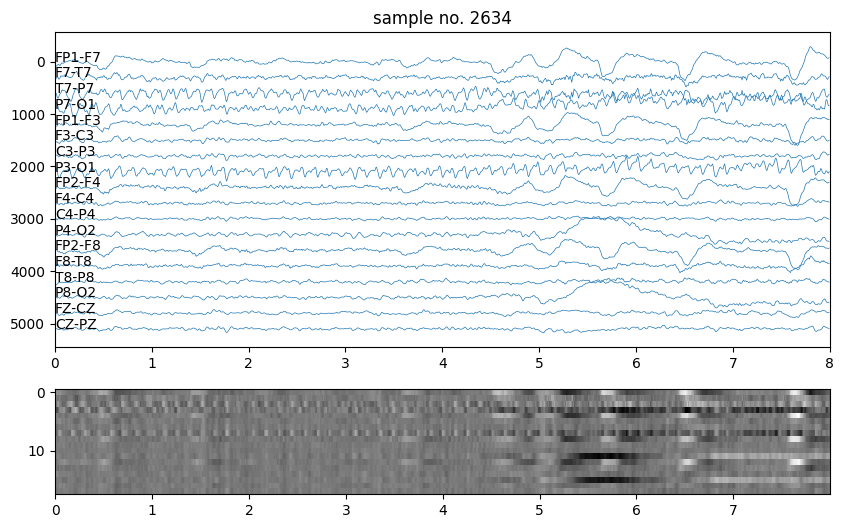

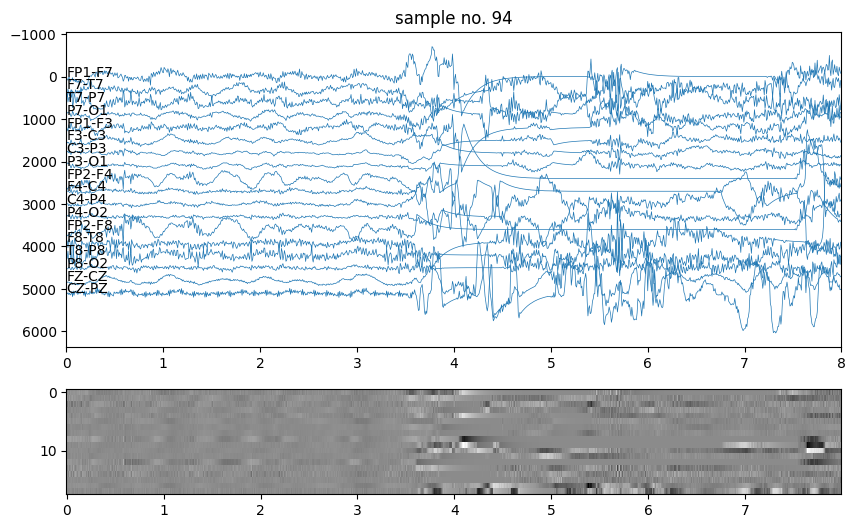

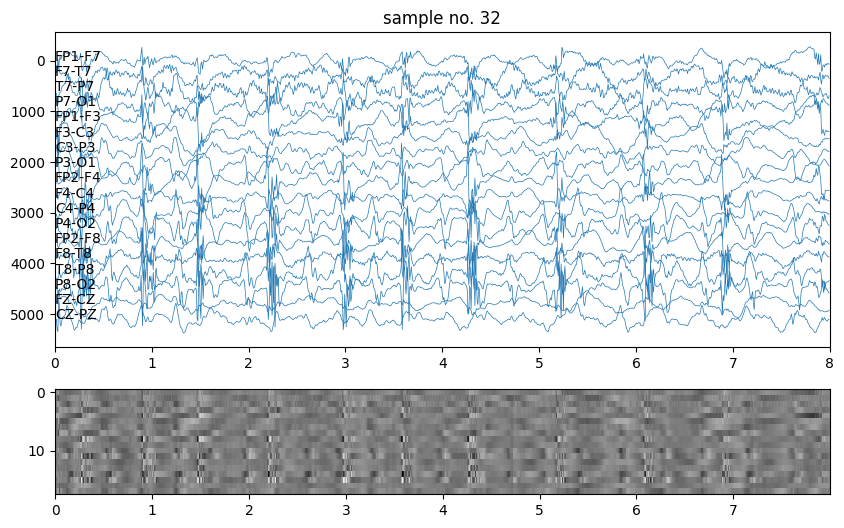

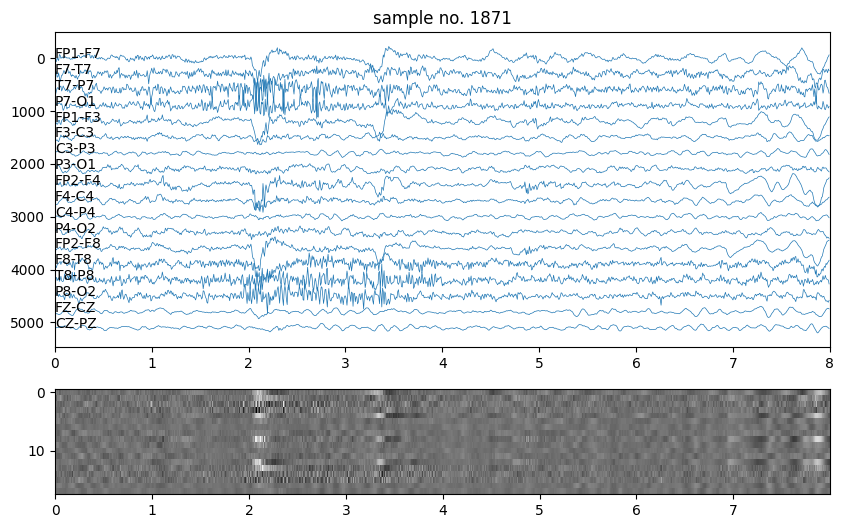

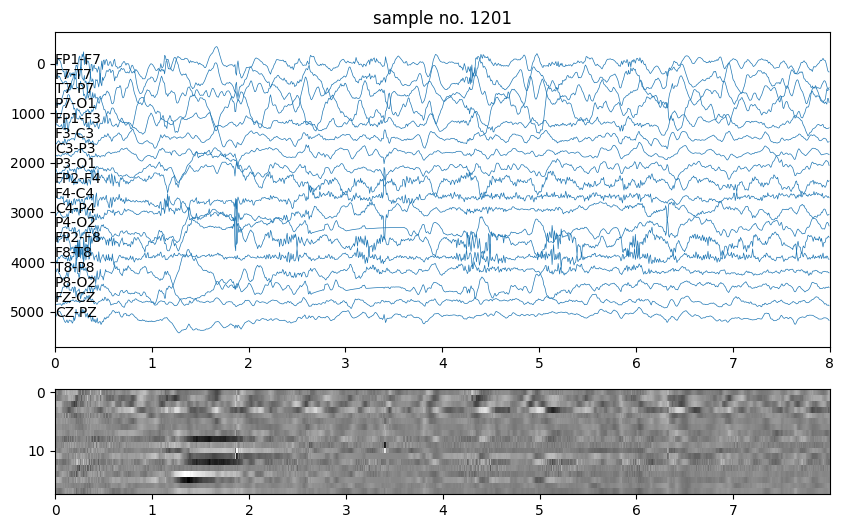

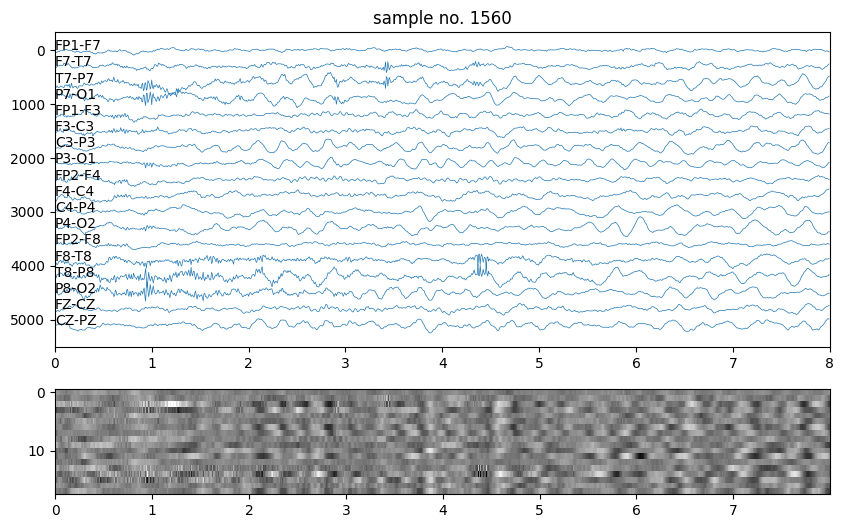

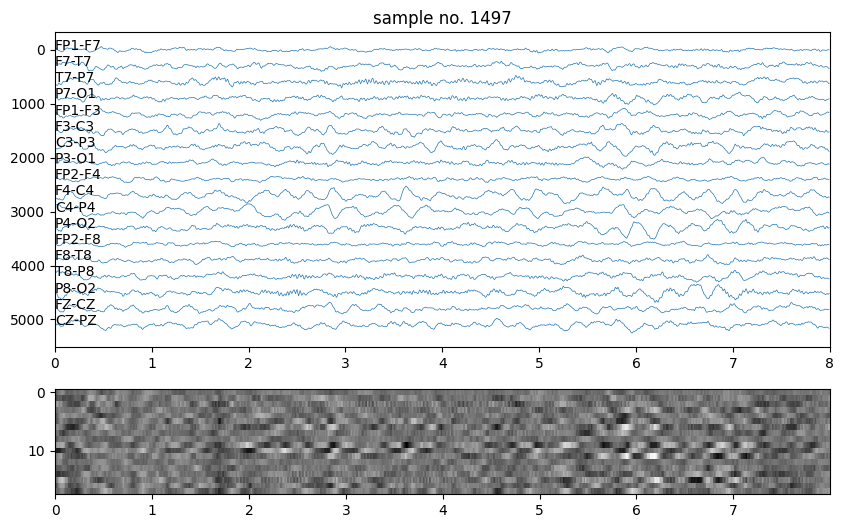

In [ ]:
# Let's see samples with seizures.

for n in random.sample(list(array_n), 10):

    vertical_width = 300
    temp_signals = array_signals[n, :, :]
    fs = 128

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1])/fs, temp_signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i*vertical_width))
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title('sample no. {}'.format(n))

    ax[1].pcolormesh(np.arange(temp_signals.shape[-1])/fs, np.arange(len(ch_labels)), temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()

    plt.show()

## Model selection, Model training on CHB-MIT EEG Database

In [ ]:
# CNN will be used. Channel dimension is added.
array_signals = array_signals[:, :, :, np.newaxis]

array_signals.shape

(3913, 18, 1024, 1)

In [ ]:
# splitting training data into training & validation data.
from sklearn import model_selection

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    array_signals, array_is_sz, test_size=0.3,
    stratify=(array_is_sz>0))

# del array_signals, array_is_sz

### Building and training deep learning models with Keras


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
model = keras.models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 18, 1024, 64)      576       
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 512, 64)       32832     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 18, 256, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 18, 256, 128)      65664     
                                                                 
 conv2d_9 (Conv2D)           (None, 18, 128, 128)      131200    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 9, 64, 128)        0         
 g2D)                                                 

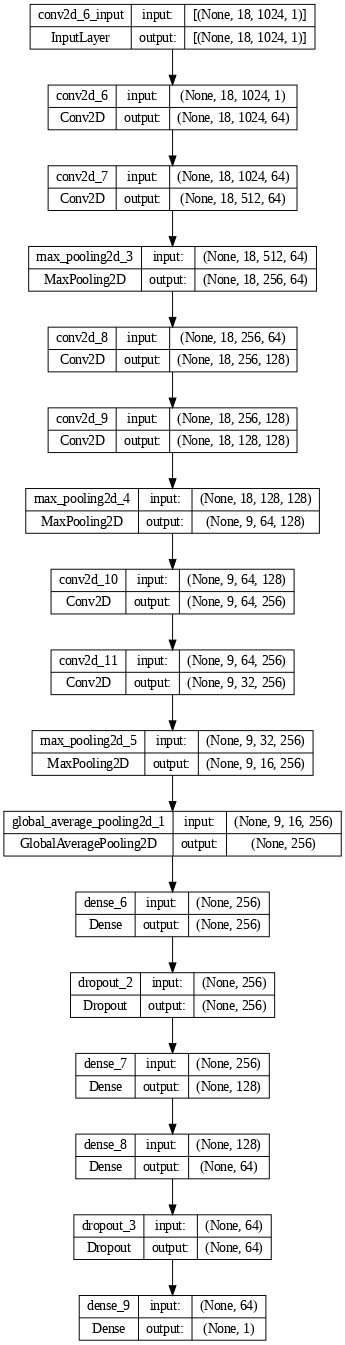

In [ ]:
from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='model.png')
plot_model(model, show_shapes=True, dpi=70)

In [ ]:
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# callbacks
VERBOSE=1
#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2739, 18, 1024, 1), (2739,), (1174, 18, 1024, 1), (1174,))

In [ ]:
import pickle

In [ ]:
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=256,
    callbacks=callbacks
)
# Save the training history to a file
with open('training_history.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

Epoch 1/30
11/11 [==============================] - 778s 71s/step - loss: 0.7300 - accuracy: 0.6134 - val_loss: 0.6208 - val_accuracy: 0.6593
Epoch 2/30
11/11 [==============================] - 739s 67s/step - loss: 0.6338 - accuracy: 0.6524 - val_loss: 0.6098 - val_accuracy: 0.6593
Epoch 3/30
11/11 [==============================] - 735s 68s/step - loss: 0.6290 - accuracy: 0.6553 - val_loss: 0.6132 - val_accuracy: 0.6593
Epoch 4/30
11/11 [==============================] - 733s 67s/step - loss: 0.6230 - accuracy: 0.6590 - val_loss: 0.6089 - val_accuracy: 0.6593
Epoch 5/30
11/11 [==============================] - 728s 67s/step - loss: 0.6195 - accuracy: 0.6590 - val_loss: 0.6002 - val_accuracy: 0.6593
Epoch 6/30
11/11 [==============================] - 719s 66s/step - loss: 0.6075 - accuracy: 0.6623 - val_loss: 0.5849 - val_accuracy: 0.6678
Epoch 7/30
10/11 [==========================>...] - ETA: 59s - loss: 0.5952 - accuracy: 0.6656 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

### Evaluating the model with test data

In [ ]:
model = keras.models.load_model('/content/CHB_MIT_sz_detec_demo.h5')

In [ ]:
def sampling_data_pred(f, verbose=True):
    list_signals = []
    list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        #else:
            #print('No sz.', end=' ')

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [ ]:
# reading files and prediction

list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]

    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

100%|██████████| 25/25 [45:10<00:00, 108.43s/it]


In [ ]:
from sklearn import metrics

In [ ]:
# threshold = 0.9
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
print(report)

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     33250
        True       0.55      0.47      0.51       629

    accuracy                           0.98     33879
   macro avg       0.77      0.73      0.75     33879
weighted avg       0.98      0.98      0.98     33879



In [ ]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))

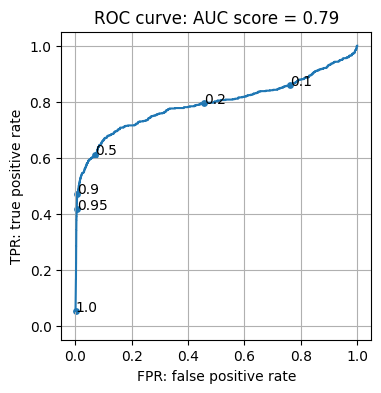

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

In [ ]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

Index = 0 has seizures: /content/test/chb01/chb01_03.edf
Index = 1 has seizures: /content/test/chb01/chb01_18.edf
Index = 2 has seizures: /content/test/chb01/chb01_15.edf
Index = 3 has seizures: /content/test/chb01/chb01_26.edf
Index = 4 has seizures: /content/test/chb01/chb01_16.edf
Index = 5 has seizures: /content/test/chb01/chb01_04.edf
Index = 6 has seizures: /content/test/chb01/chb01_21.edf
Index = 7 has seizures: /content/test/chb07/chb07_12.edf
Index = 8 has seizures: /content/test/chb07/chb07_13.edf
Index = 9 has seizures: /content/test/chb07/chb07_19.edf
Index = 10 has seizures: /content/test/chb08/chb08_11.edf
Index = 11 has seizures: /content/test/chb08/chb08_02.edf
Index = 12 has seizures: /content/test/chb08/chb08_13.edf
Index = 13 has seizures: /content/test/chb08/chb08_05.edf
Index = 14 has seizures: /content/test/chb08/chb08_21.edf
Index = 15 has seizures: /content/test/chb10/chb10_27.edf
Index = 16 has seizures: /content/test/chb10/chb10_38.edf
Index = 17 has seizures:

RNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define RNN Model
model_rnn = keras.Sequential([
    layers.SimpleRNN(64, activation='relu', input_shape=(time_window, len(ch_labels))),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_rnn.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print("Current shape of array_signals:", array_signals.shape)

Current shape of array_signals: (3913, 18, 1024, 1)


In [ ]:
# Reshaping Data for RNN
# Squeeze the last dimension
array_signals_squeezed = np.squeeze(array_signals, axis=-1)

# Transpose to have the shape (samples, timesteps, channels)
X_reshaped_rnn = array_signals_squeezed.transpose(0, 2, 1)

# Get the values for timesteps and channels
timesteps, channels = X_reshaped_rnn.shape[1:]

In [ ]:
# Split the data into training and validation sets
from sklearn import model_selection

X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = model_selection.train_test_split(
    X_reshaped_rnn, array_is_sz, test_size=0.3,
    stratify=(array_is_sz > 0))

In [ ]:
# Define EarlyStopping callback
from keras.callbacks import EarlyStopping

VERBOSE = 1
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

In [ ]:
X_train_rnn.shape, y_train_rnn.shape, X_val_rnn.shape, y_val_rnn.shape

((2739, 1024, 18), (2739,), (1174, 1024, 18), (1174,))

In [ ]:
# Building RNN Model


model_rnn = keras.Sequential([
    layers.SimpleRNN(64, activation='relu', input_shape=(timesteps, channels)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Training the RNN Model

history_rnn = model_rnn.fit(
    X_train_rnn, y_train_rnn,
    validation_data=(X_val_rnn, y_val_rnn),
    epochs=20,
    batch_size=256,
    callbacks=[es]
)

Epoch 1/20
11/11 [==============================] - 8s 519ms/step - loss: 8.7318 - accuracy: 0.5717 - val_loss: 5.9374 - val_accuracy: 0.5869
Epoch 2/20
11/11 [==============================] - 5s 485ms/step - loss: 4.2464 - accuracy: 0.6083 - val_loss: 4.5119 - val_accuracy: 0.5937
Epoch 3/20
11/11 [==============================] - 7s 614ms/step - loss: 3.0344 - accuracy: 0.6090 - val_loss: 3.9954 - val_accuracy: 0.6005
Epoch 4/20
11/11 [==============================] - 5s 460ms/step - loss: 2.3720 - accuracy: 0.6265 - val_loss: 3.6442 - val_accuracy: 0.6022
Epoch 5/20
11/11 [==============================] - 6s 544ms/step - loss: 1.9518 - accuracy: 0.6462 - val_loss: 3.4527 - val_accuracy: 0.5997
Epoch 6/20
11/11 [==============================] - 6s 562ms/step - loss: 1.6781 - accuracy: 0.6601 - val_loss: 3.4290 - val_accuracy: 0.5860
Epoch 7/20
11/11 [==============================] - 5s 472ms/step - loss: 1.4400 - accuracy: 0.6656 - val_loss: 3.1202 - val_accuracy: 0.6014
Epoch 

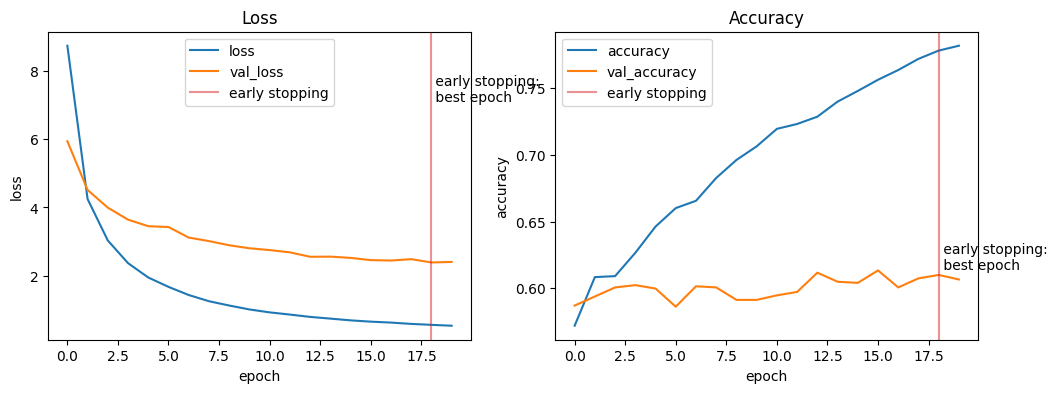

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot Loss
ax[0].plot(history_rnn.history['loss'], label='loss')
ax[0].plot(history_rnn.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r * min(history_rnn.history['loss']) + (1 - r) * max(history_rnn.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

# Plot Accuracy
ax[1].plot(history_rnn.history['accuracy'], label='accuracy')
ax[1].plot(history_rnn.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r * min(history_rnn.history['accuracy']) + (1 - r) * max(history_rnn.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [ ]:
def sampling_data_pred_rnn(f, verbose=True):
    list_signals = []
    list_is_sz = []

    if verbose:
        print('{}: Reading.'.format(f))

    # Read the EEG data using mne
    temp_edf = mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names

    # Check if the channel labels are appropriate
    if sum([any([0 if re.match(c, l) == None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) != None])[0]: c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)

        # Extract seizure indicator
        temp_is_sz = np.zeros((temp_edf.n_times,))
        if os.path.exists(f + '.seizures'):
            if verbose:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

        # Extract EEG signals
        temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6
        temp_len = temp_edf.n_times

        # Define parameters for sampling
        time_window = 4
        time_step = 2
        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))
        step_window = time_window * fs
        step = time_step * fs

        # Sample signals for the RNN model
        temp_array_signals = np.array([temp_signals[:, i * step:i * step + step_window] for i in range((temp_len - step_window) // step)])
        temp_is_sz_ind = np.array([temp_is_sz[i * step:i * step + step_window].sum() / step_window for i in range((temp_len - step_window) // step)])

        return temp_array_signals, temp_is_sz_ind

    else:
        if verbose:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(f))
        return None, None


In [ ]:
# Usage for RNN model

from sklearn import metrics

list_pred_rnn = []
list_true_rnn = []

for f in tqdm.tqdm(files_test):
    array_signals_rnn, array_is_sz_rnn = sampling_data_pred_rnn(f, verbose=False)

    # Assuming you have reshaped array_signals_rnn if needed
    array_signals_rnn_reshaped = array_signals_rnn.transpose(0, 2, 1)

    list_pred_rnn.append(model_rnn.predict(array_signals_rnn_reshaped, verbose=0))
    list_true_rnn.append(array_is_sz_rnn)


100%|██████████| 25/25 [03:19<00:00,  7.96s/it]


In [ ]:
# Evaluate RNN model
Threshold = 0.9 #(chosen threshold)
report_rnn = metrics.classification_report(np.concatenate(list_true_rnn) > 0, np.concatenate(list_pred_rnn) > Threshold)
print(report_rnn)

              precision    recall  f1-score   support

       False       0.99      0.60      0.75     66604
        True       0.03      0.61      0.05      1207

    accuracy                           0.60     67811
   macro avg       0.51      0.60      0.40     67811
weighted avg       0.97      0.60      0.73     67811



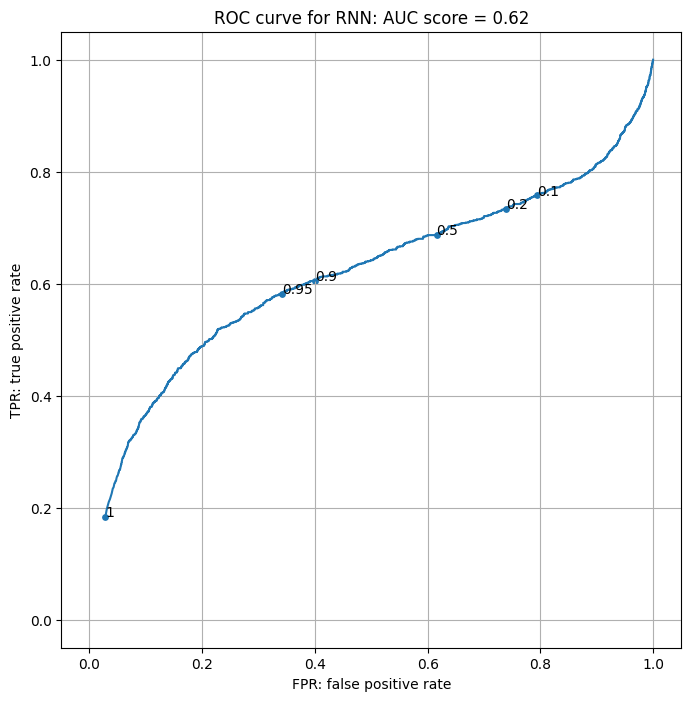

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming list_true_rnn and list_pred_rnn are defined
roc_rnn = metrics.roc_curve(np.concatenate(list_true_rnn) > 0, np.concatenate(list_pred_rnn))
auc_rnn = metrics.roc_auc_score(np.concatenate(list_true_rnn) > 0, np.concatenate(list_pred_rnn))

plt.figure(figsize=(8, 8))
plt.plot(roc_rnn[0][np.argmin(np.abs(roc_rnn[2] - 1)):], roc_rnn[1][np.argmin(np.abs(roc_rnn[2] - 1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve for RNN: AUC score = {:.2f}'.format(auc_rnn))

th = [.1, .2, .5, .9, .95, 1]
ind = [np.argmin(np.abs(roc_rnn[2] - l)) for l in th]
plt.scatter(roc_rnn[0][ind], roc_rnn[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc_rnn[0][l], roc_rnn[1][l]))

plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
plt.show()

